<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack

part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An Introduction into tegistration of an image stack.

This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1
    
    This test does not require a loading of the packages
    """
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyNSID/ -q
    !pip install git+https://github.com/pycroscopy/sidpy/ -q
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q
else:
    # pyTEMlib setup ------------------
    if test_package('pyTEMlib') < '0.2022.1.6':
        !{sys.executable} -m pip install  --upgrade git+https://github.com/pycroscopy/pyTEMlib
        print('installed pyTEMlib')
    if test_package('sidpy') < '0.0.4':
        !{sys.executable} -m pip install  --upgrade sidpy -q
        print('installed sidpy')
    if test_package('pyNSID') < '0.0.1':
        !{sys.executable} -m pip install  --upgrade  git+https://github.com/pycroscopy/pyNSID -q
        print('Installed pyNSID')
# ------------------------------
print('done')

done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
%matplotlib  notebook
import matplotlib.pyplot as plt
import numpy as np
import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0,'../../')

import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2022_12_16'
%gui qt

Symmetry functions of spglib enabled
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
pyTEM version:  0.2022.12.1


## Open File

### Choose Mode of  File Selection

Here you can choose between a ``FileWidget`` or a ``FileDialog`` to select a file.

The FileWidget will use display the name of a Nion File like in NionSwift and is often the better way for those files. 

The ``FileDialog`` does not work on ``Google Colab`` and thus the ``FileWidget`` will be used automatically.

In [ ]:
datasets = ft.open_file()
chooser = ft.ChooseDataset(datasets)

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

In [ ]:
dataset = chooser.dataset

if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image here')

view = dataset.plot()

In [5]:
dataset.rechunk([1,1024,1024])

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<rechunk-merge, shape=(20, 1024, 1024), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  time (frame) of size (20,)
x:  distance (nm) of size (1024,)
y:  distance (nm) of size (1024,)
 with metadata: ['experiment', 'filename']

## First: Rigid Registration

If this is an image stack we need to register and add the images. 

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

Stack contains  20  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


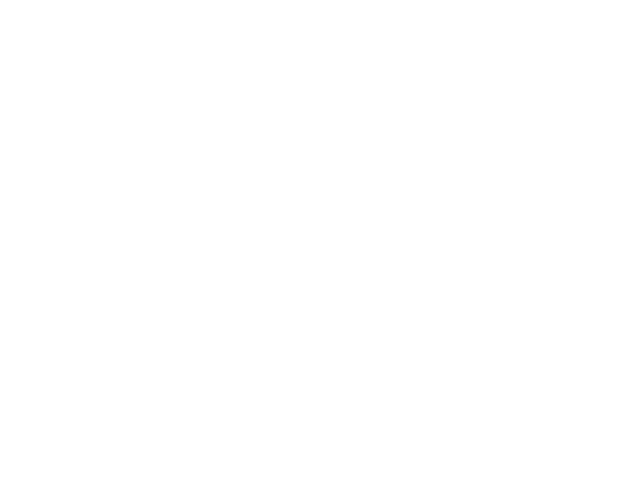

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(20, 676, 869), dtype=float64, chunksize=(20, 676, 869), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
frame:  time (frame) of size (20,)
x:  distance (x) of size (676,)
y:  distance (y) of size (869,)
 with metadata: ['analysis', 'drift', 'input_crop', 'input_shape']

In [8]:
rig_reg_dataset = it.rigid_registration(dataset)

view = rig_reg_dataset.plot()
rig_reg_dataset

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

<IPython.core.display.Javascript object>


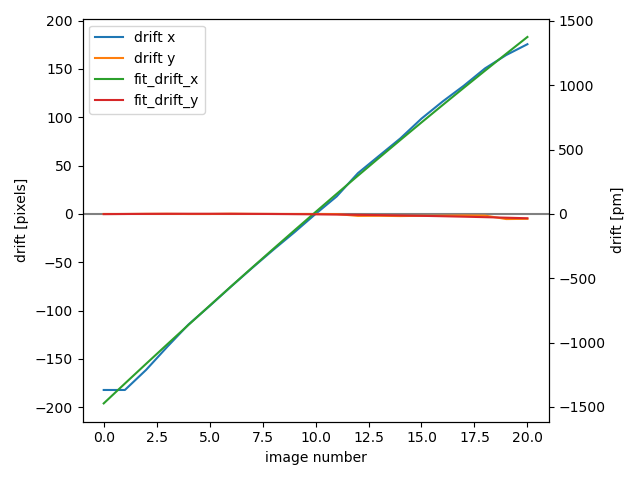

In [10]:
scale_x = ft.get_slope(rig_reg_dataset.x.values)*1000.
drift = rig_reg_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.13


<IPython.core.display.Javascript object>


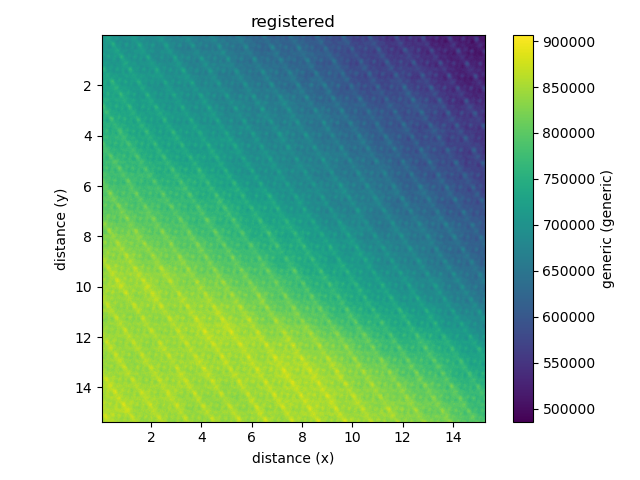

In [14]:
image = rig_reg_dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

image.set_dimension(0,rig_reg_dataset.dim_1)
image.set_dimension(1,rig_reg_dataset.dim_2)
print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view =image.plot()


### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [20]:
datasets['Log_000'] = LR_dataset


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

  0%|          | 0/20 [00:00<?, ?it/s]

:-)
You have successfully completed Diffeomorphic Demons Registration


<IPython.core.display.Javascript object>


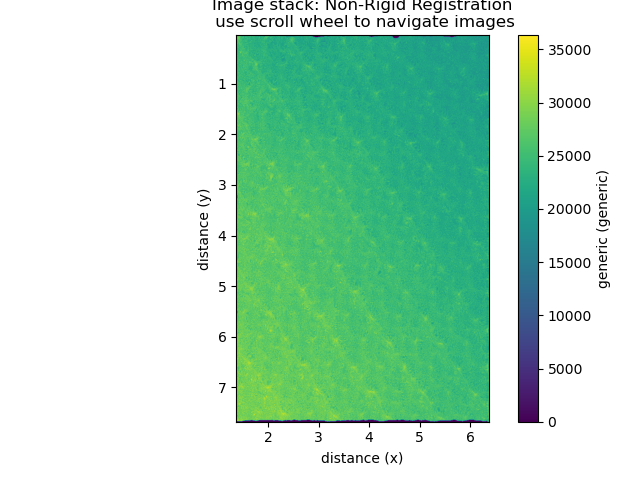

In [11]:
non_rigid_registered = it.demon_registration(rig_reg_dataset)

view = non_rigid_registered.plot()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.14


<IPython.core.display.Javascript object>


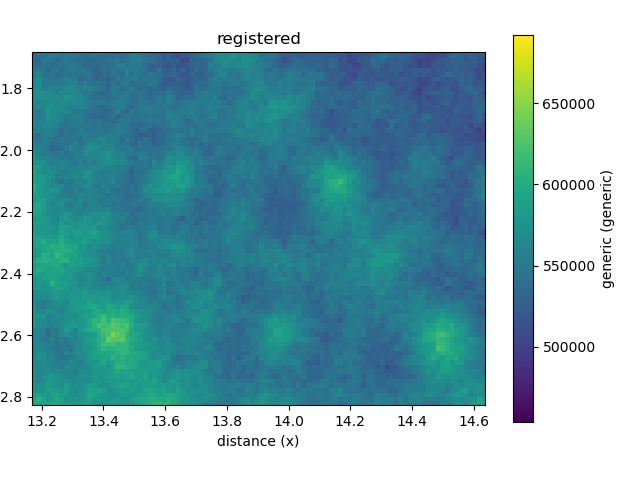

In [16]:
image = non_rigid_registered.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'
image.set_dimension(0,non_rigid_registered.dim_1)
image.set_dimension(1,non_rigid_registered.dim_2)

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()

### Log Non-Rigid Registration

In [21]:
datasets['Log_001'] = non_rigid_registered

A tree-like plot of the file

## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [5]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: HAADF', 'Channel_001: HAADF', 'Log_000: Rigid R…

The selected dataset can then easily be plotted

<IPython.core.display.Javascript object>


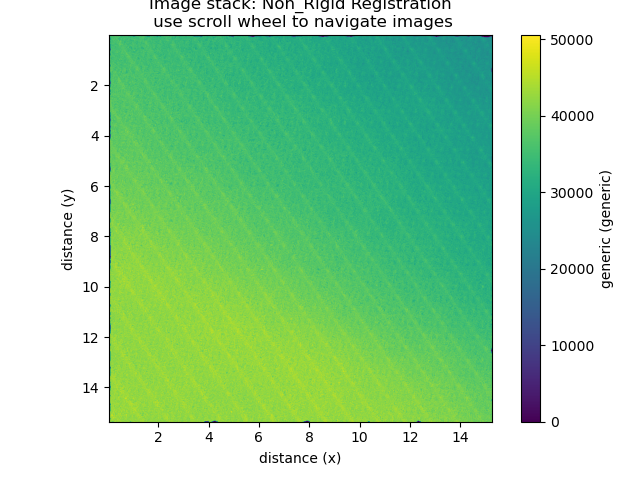

In [3]:
view = chooser.dataset.plot()

## Save File
let's save the datasets

In [31]:
h5_group = ft.save_dataset(datasets, filename=dataset.metadata['filename'])

/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/pyNSID/io/hdf_utils.py:374: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/pyNSID/io/hdf_utils.py:374: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/pyNSID/io/hdf_utils.py:374: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/pyNSID/io/hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted'
/home/nyd/anaconda3/envs/ase/li

In [33]:
print('original file ', dataset.metadata['filename'])
print('was sved to: '+ h5_group.file.filename)

original file  /mnt/c/Users/gduscher/Documents/2022-Experiment/gduscher/20221209/STEM HAADF 1712.emd
was sved to: /mnt/c/Users/gduscher/Documents/2022-Experiment/gduscher/20221209/STEM HAADF 1712.hf5


Please note, that the file is still open, so we need to close it.

In [ ]:
h5_group.file.close()

### Adaptive Fourier Filter 

In [ ]:
chooser = ft.ChooseDataset(datasets)

Contrast = 0.14


<IPython.core.display.Javascript object>


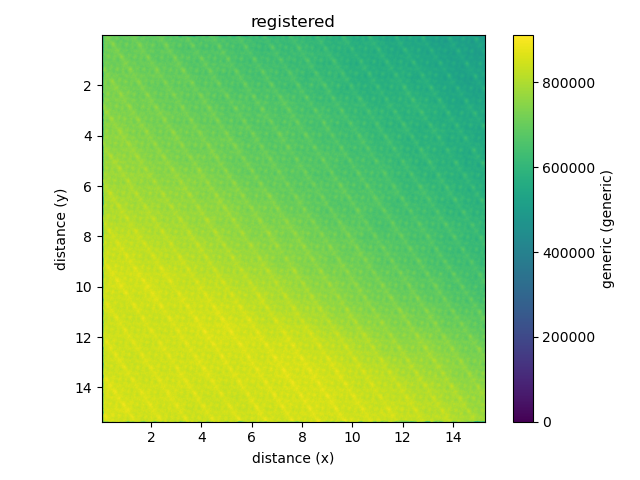

In [3]:
dataset = chooser.dataset
image = dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()


fft :
	smoothing : 1
	minimum_intensity : 14.971004411718841
	maximum_intensity : 21.955855849170504
source:  registered


<IPython.core.display.Javascript object>


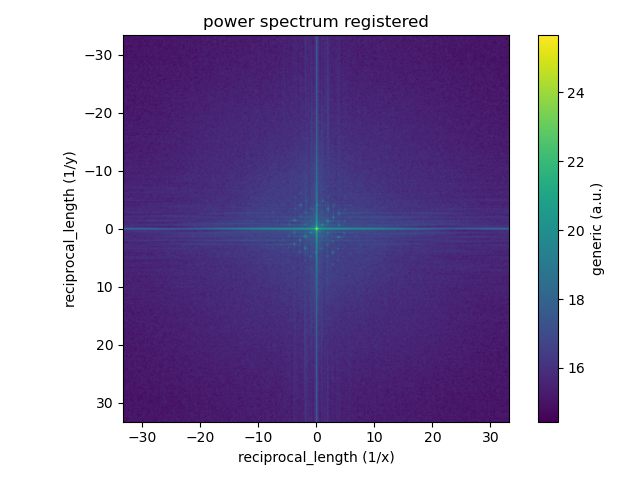

In [4]:
power_spectrum = it.power_spectrum(image, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

In [ ]:
# ------Input----------
spot_threshold=0.03
# ---------------------

spots = it.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<8,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
spots = spots[np.abs(spots[:,0])> .0001]
spots = spots[np.abs(spots[:,1])> .0001]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4)

<IPython.core.display.Javascript object>


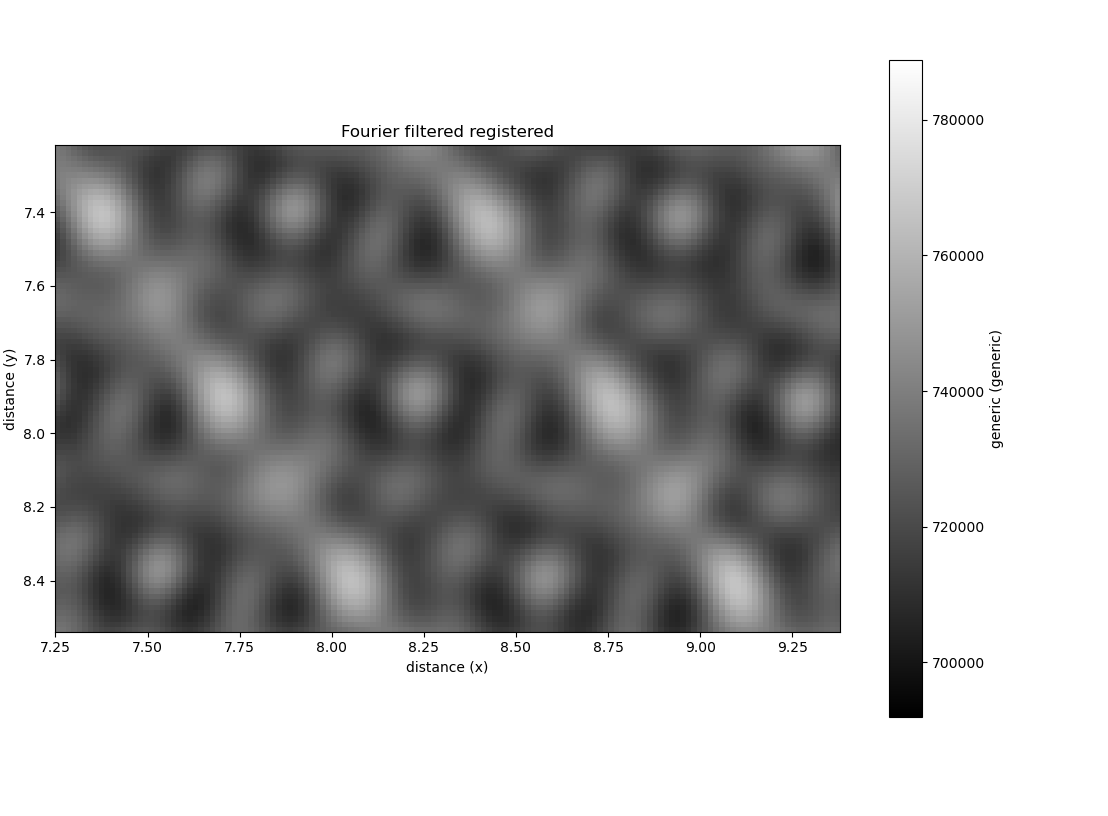

In [10]:
filtered_dataset = it.adaptive_fourier_filter(image, spots, low_pass=.03, reflection_radius=.3)
view = filtered_dataset.plot(cmap='gray')